In [107]:
import numpy as np
import matplotlib.pyplot as plt

# Problem 1 (K-means)

## Generate Gaussian Mixtures

In [3]:
data = np.vstack((np.random.multivariate_normal(np.array([0, 0]), np.array([[1, 0], [0, 1]]), 100),
                  np.random.multivariate_normal(np.array([3, 0]), np.array([[1, 0], [0, 1]]), 250),
                  np.random.multivariate_normal(np.array([0, 3]), np.array([[1, 0], [0, 1]]), 150)))
print(data.shape)

(500, 2)


## Implement k-means

In [24]:
def k_means(X, n_clusters, max_iter):
    centroid = X[np.random.choice(np.arange(X.shape[0]), n_clusters, False), :]
    label = np.zeros(X.shape[0], dtype='uint16')
    record = np.zeros(max_iter)
    for i in range(max_iter):
        n_k = np.zeros(n_clusters)
        new_centroid = np.zeros(centroid.shape)
        for j in range(X.shape[0]):
            label[j] = minimum(X[j, :], centroid)
            n_k[label[j]] += 1
            new_centroid[label[j], :] = np.add(new_centroid[label[j], :], X[j, :])
        for k in range(n_k.size):
            new_centroid[k, :] /= n_k[k]
        centroid = new_centroid
        for j in range(X.shape[0]):
            record[i] += np.linalg.norm(np.subtract(X[j, :], centroid[label[j]])) ** 2
    %matplotlib inline
    plt.plot(record); plt.show()
    return label, centroid
            
def minimum(point, centroid):
    minimum, min_ind = float('Inf'), -1
    for i in range(centroid.shape[0]):
        candidate = np.linalg.norm(np.subtract(point, centroid[i, :]))
        if candidate < minimum:
            minimum, min_ind = candidate, i
    return min_ind

## Plots

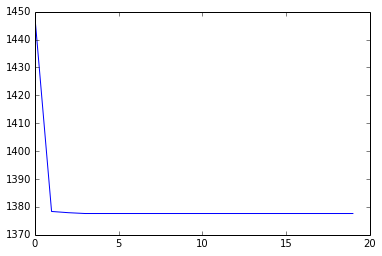

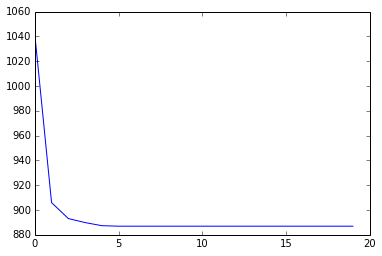

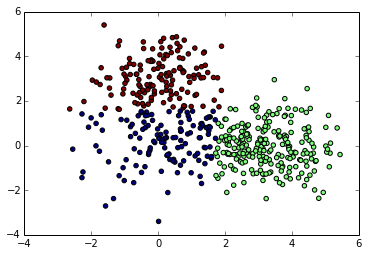

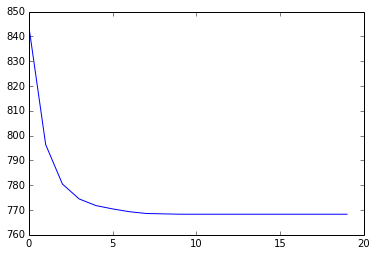

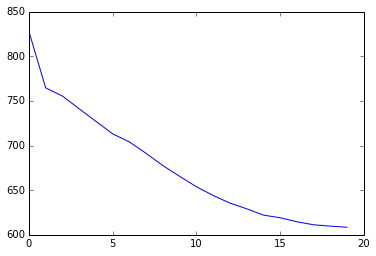

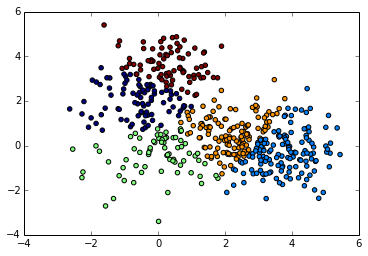

In [25]:
%matplotlib inline
for i in range(2, 6):
    label, centroid = k_means(data, i, 20)
    if i in (3, 5):
        plt.scatter(data[:, 0], data[:, 1], c=label)
        plt.show()

# Problem 2 (Matrix factorization)

## Implement MAP collaborative filtering

In [79]:
class MapMatComp(object):
    def __init__(self, sigma_square=0.25, d=10, lanbda=10.0):
        self.sigma_square = sigma_square
        self.d = d
        self.lanbda = lanbda
        self.u = None; self.v = None
        self.likelihood = []; self.rmse = []
    
    def fit(self, mat, n_iter=100, N1=943, N2=1682, test_file='ratings_test.txt'):
        self.u = np.random.multivariate_normal(np.zeros(self.d), (1/float(self.lanbda)) * np.eye(self.d), N1)
        self.v = np.random.multivariate_normal(np.zeros(self.d), (1/float(self.lanbda)) * np.eye(self.d), N2)
        for i in range(n_iter):
            for j in range(N1):
                left = self.lanbda * self.sigma_square * np.eye(self.d)
                right = np.zeros(self.d)
                for k in range(N2):
                    if mat[j, k] > 0:
                        right = np.add(right, mat[j, k]*self.v[k, :])
                        left = np.add(left, np.outer(self.v[k, :], self.v[k, :]))
                self.u[j, :] = np.dot(np.linalg.inv(left), right[:, None]).ravel()
            for j in range(N2):
                left = self.lanbda * self.sigma_square * np.eye(self.d)
                right = np.zeros(self.d)
                for k in range(N1):
                    if mat[k, j] > 0:
                        right = np.add(right, mat[k, j]*self.u[k, :])
                        left = np.add(left, np.outer(self.u[k, :], self.u[k, :]))
                self.v[j, :] = np.dot(np.linalg.inv(left), right[:, None]).ravel()
            likelihood = 0
            for j in range(mat.shape[0]):
                for k in range(mat.shape[1]):
                    if mat[j, k] > 0:
                        likelihood -= (mat[j, k] - np.dot(self.u[j, :], self.v[k, :])) ** 2
            likelihood /= (2 * self.sigma_square)
            for j in range(self.u.shape[0]):
                likelihood -= self.lanbda * (np.linalg.norm(self.u[j, :]) ** 2) / 2
            for j in range(self.v.shape[0]):
                likelihood -= self.lanbda * (np.linalg.norm(self.v[j, :]) ** 2) / 2
            rmse = self.predict(test_file)
            print(likelihood, rmse)
            self.likelihood.append(likelihood)
            self.rmse.append(rmse)
                        
    
    def predict(self, file_name):
        import csv
        from sklearn.metrics import mean_squared_error as mse
        y_test = []; y_predict = []
        with open(file_name) as f:
            for row in csv.reader(f):
                if len(row) == 3:
                    y_predict.append(round(np.dot(self.u[int(row[0])-1, :], self.v[int(row[1])-1, :])))
                    y_test.append(float(row[2]))
        return np.sqrt(mse(np.array(y_test), np.array(y_predict)))

## Load Data & Training

In [80]:
import csv

mat = np.zeros((943, 1682))
with open('ratings.txt') as f:
    for row in csv.reader(f):
        if len(row) == 3:
            mat[int(row[0])-1, int(row[1])-1] = float(row[2])
recommend = MapMatComp()
recommend.fit(mat)

(-717127.03683562437, 2.174350477728924)
(-173388.07758945067, 1.0117311895953391)
(-158675.64871196717, 1.0014988766843425)
(-154026.70118195104, 1.0005998201079191)
(-151829.27452898538, 1.0017983829094554)
(-150623.48423506491, 1.0001999800039989)
(-149881.80770031281, 1.0039920318408906)
(-149377.82513318796, 1.0048880534666536)
(-149007.10697316128, 1.0041912168506553)
(-148717.74557593581, 1.0036931802099684)
(-148481.83200002994, 1.0010993956645864)
(-148283.5030230738, 1.0035935432235503)
(-148113.26440725269, 1.0064790112068904)
(-147965.06239842658, 1.004290794541103)
(-147834.780934707, 1.0048880534666536)
(-147719.47596837097, 1.0046890066085128)
(-147616.97401849864, 1.0053854982045445)
(-147525.61277958954, 1.0071742649611337)
(-147444.04613619775, 1.0068763578513502)
(-147371.11554956451, 1.0062802790475425)
(-147305.78497282646, 1.0057832768544126)
(-147247.11639116914, 1.0040916292848974)
(-147194.26301121464, 1.005186549850325)
(-147146.46684018642, 1.005087060905671)

## Plots

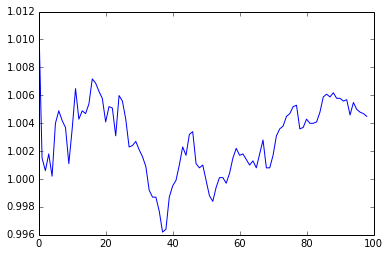

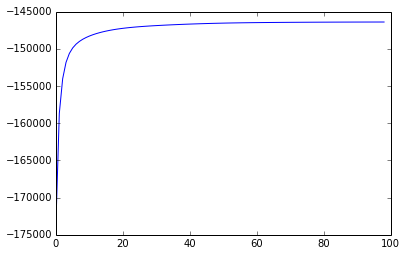

In [84]:
%matplotlib inline
plt.plot(recommend.rmse[1:])
plt.show()
plt.plot(recommend.likelihood[1:])
plt.show()

## Find affinity movies

In [89]:
base_movies = [1, 50, 487]
for base in base_movies:
    distance = []
    for i in range(recommend.v.shape[0]):
        distance.append((i+1, np.linalg.norm(np.subtract(recommend.v[i], recommend.v[base-1]))))
    ind, dist = zip(*sorted(distance, key=lambda x: x[1])[:6])
    with open('movies.txt') as f:
        count = 1
        for line in f:
            if count in ind:
                print(str(dist[ind.index(count)])+' '+line)
            count += 1
    print('')

0.0 Toy Story (1995)

0.619304121769 Babe (1995)

0.711210658208 Searching for Bobby Fischer (1993)

0.683822132479 Aladdin (1992)

0.669550568157 Return of the Pink Panther, The (1974)

0.681705397292 Indiana Jones and the Last Crusade (1989)


0.0 Star Wars (1977)

0.276554634511 Empire Strikes Back, The (1980)

0.686696193527 Raiders of the Lost Ark (1981)

0.501893965932 Return of the Jedi (1983)

0.791751757796 Blues Brothers, The (1980)

0.898083425627 Star Trek: The Wrath of Khan (1982)


0.561054565061 Snow White and the Seven Dwarfs (1937)

0.529803774235 North by Northwest (1959)

0.532199356626 Casablanca (1942)

0.0 Roman Holiday (1953)

0.537460384472 To Catch a Thief (1955)

0.565022347391 Manchurian Candidate, The (1962)




## Cluster on users

In [105]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=20)
cluster.fit(recommend.u)
counts = np.zeros(20)
for label in cluster.labels_:
    counts[label] += 1
ind = np.argsort(counts)[15:20]
for i in range(ind.size):
    print(counts[ind[i]])
    print(cluster.cluster_centers_[ind[i], :])
    distance = np.zeros(recommend.v.shape[0])
    for j in range(recommend.v.shape[0]):
        distance[j] = np.dot(recommend.v[j, :], cluster.cluster_centers_[ind[i], :])
    top_ind = np.argsort(distance)[distance.size-10:distance.size]
    with open('movies.txt') as f:
        count = 0
        for line in f:
            if count in top_ind:
                print(unicode(line[:-1], 'utf8') + ' ' + str(distance[count]))
            count += 1

62.0
[-0.31323655  0.41981868  0.58567958  0.87976441  0.96395996 -1.06203204
 -0.54490062  0.91917021  0.45774257 -0.59606361]
Star Wars (1977) 4.45514804449
Shawshank Redemption, The (1994) 4.45183872006
Godfather, The (1972) 4.46722884184
Citizen Kane (1941) 4.43195417767
Chasing Amy (1997) 4.56552491502
In the Company of Men (1997) 4.50408016345
Wag the Dog (1997) 4.56301657939
Casablanca (1942) 4.47775760765
Kundun (1997) 4.43928222712
Some Folks Call It a Sling Blade (1993) 4.54300466615
63.0
[-0.52035147  0.35378268  0.92595641  0.14892151  0.89567213 -0.79366501
 -1.02880906  0.70122522  0.12811957 -0.5294529 ]
Three Colors: Red (1994) 4.4044972693
Three Colors: Blue (1993) 4.49447416566
Fargo (1996) 4.48872680591
Wallace & Gromit: The Best of Aardman Animation (1996) 4.4860721051
Lone Star (1996) 4.439172178
Big Night (1996) 4.41668352886
Clockwork Orange, A (1971) 4.62056525855
Kolya (1996) 4.46768389595
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (19

## Cluster on movies

In [106]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=20)
cluster.fit(recommend.v)
counts = np.zeros(20)
for label in cluster.labels_:
    counts[label] += 1
ind = np.argsort(counts)[15:20]
for i in range(ind.size):
    print(counts[ind[i]])
    print(cluster.cluster_centers_[ind[i], :])
    distance = np.zeros(recommend.v.shape[0])
    for j in range(recommend.v.shape[0]):
        distance[j] = np.linalg.norm(np.subtract(recommend.v[j, :], cluster.cluster_centers_[ind[i], :]))
    top_ind = np.argsort(distance)[:10]
    with open('movies.txt') as f:
        count = 0
        for line in f:
            if count in top_ind:
                print(unicode(line[:-1], 'utf8') + ' ' + str(distance[count]))
            count += 1

105.0
[-0.68554561  0.3398665   0.04338228 -0.02954462  0.75271241 -1.13923248
 -0.76571332  0.72288537  0.19274382 -0.55766827]
20,000 Leagues Under the Sea (1954) 0.41702538693
12 Angry Men (1957) 0.452580072061
Casablanca (1942) 0.442631626793
Roman Holiday (1953) 0.489462602778
To Catch a Thief (1955) 0.32618852061
Thin Man, The (1934) 0.467910021166
African Queen, The (1951) 0.413250763978
American in Paris, An (1951) 0.479087863329
Rear Window (1954) 0.479784478262
Arsenic and Old Lace (1944) 0.413477930517
107.0
[-0.08670361  0.1401618  -0.24240753  0.4787516   0.57375253 -0.70889747
 -0.08438435  0.77248156  0.17200016 -0.21513649]
Sgt. Bilko (1996) 0.482410732318
Batman & Robin (1997) 0.460500731993
Made in America (1993) 0.505495516666
I Love Trouble (1994) 0.469667264548
Twisted (1996) 0.454779986801
Specialist, The (1994) 0.503535211948
Moonlight and Valentino (1995) 0.458393249521
Scarlet Letter, The (1995) 0.423657514386
Visitors, The (Visiteurs, Les) (1993) 0.45684062003